# Laboratory of Computational Physics - Year 3

### Group 1 - Matteo De Tullio, Francesca Dodici, Arianna Mischianti, Pierpaolo Ranieri 



## Tracking muons with 4 Drift Tubes chambers setup

The project consist in the analysis of the data gathered by four drift-tubes detectors during a beam test aimed at the production of $\mu^+ - \mu^-$ pairs. This was achieved by shooting 45 GeV positrons on a Beryllium target. Most of the collisons yielded background events (e.g. Bhabha scattering events), whereas only a small fraction produced an actual muons pair. A signal event would consist of two tracks, each traversing two muon detectors (as a dipole magnet deflected in different directions the positively and the negatively charged particles).

Our analysis has been conducted taking into account a several sets of calibration runs, obtained by shouting directly positive muons at a given energy on the target. Each run consists of single track on one of the two sides of the apparatus, whose side was determined by the sign of the current powering the magnet.

Each detector consists of four layers of drift-tubes, i.e. cells with an anodic wire at the center and cathods at the sides filled up with a gas mixture of ${\rm Ar-CO_2}$ ($85\%-15\%$). The passage of a charged particle through a cell ionizes the gas, with a consequent drift of electrons towards the anodic wire. 
Exploiting a linear relation (the drift velocity inside the cell is constant), by measuring the time of arrival of the primary ionization, it is possible to reconstruct the track's position within the cell. Note that there is a left-right ambiguity in the determination of the position.

## Import data

The data files are organized as a series of events (rows of a dataframe) where each event consists of the coordinates of the hits recorded in that event. The number of hits for event is not fixed, hence the dataset cannot be seen as a unique big table with a defined number of "columns". More specifically every raw contains:

* event number
* number of recorded hits (N)
* hit 1 coordinates
* ...
* hit N coordinates

where N could be zero too and the hits coordinates are: 
* *chamber*, which of the four detector registered the hit (numbering is in the range $0-4$)
* *layer*, which layer of that detector
* *xleft*, the x position of the hit **in the local detector coordinates** assuming the track passed at the left of the wire
* *xright*, the x position of the hit **in the local detector coordinates** assuming the track passed at the right of the wire
* *time*, the drift time (redundant)

The local detector coordinates are defined with respect to one side (the left one) of the detector. All the detectors however were placed as rotated by 180 degrees, i.e. the x axes of the local and global coordinates have opposite orientation.

## Including packages 

Here we include all the packages which were useful for our analysis.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.patches import Rectangle
from IPython.display import display
from scipy import stats, optimize
import matplotlib.ticker as ticker

## Detector coordinates

As previously mentioned, the spatial quantities are expressed in terms of the chamber local coordinates. In many cases it would have been more clever to perform a conversion to global coordinates. The parameters used for this conversion are shown below.

In [2]:
# Dimensions of cells
XCELL = 42.
ZCELL = 13.

# X coordinates translation
global_x_shifts = [994.2, 947.4,-267.4,-261.5,] 

# Z coordinates translations
local_z_shifts = [z*ZCELL for z in range(0,4)]
global_z_shifts = [823.5, 0, 823.5, 0] 

# Calibration runs

Four different calibration runs were collected, with different values of energy and magnetic current.  

In the following table the relevant parameters are listed:

| Run |  Energy (GeV)|  Magnet current (A)|
|-----|:---:|:-----:|
| 260 | 22 | -580 |
| 261 | 18 | -850 |
| 262 | 18 |  850 |
| 263 | 22 |  580 |

In particular we noticed that the sign of the magnetic current gives information about the side of the apparatus which will be crossed by the muons during a single event, while its module tells where we expect to find the biggest amount of hits along the x-coordinate.

In the following sections we'll start from the `"data_260.txt"` dataset to describe the general procedure and the functions utilized in the analysis of all calibration runs. The results of this analysis in all 4 cases will be displayed in the **Analysis** section.

### `Read_data`

* **Input**
    - `file_name`: Name of file containing the data 
* **Output**
    - `Events`: List of pandas dataframes, one for each event 
    - `Hit_number`: List of number of hits in each event

This function takes in input the .txt file with all the data of the run considered, and then outputs a list of Pandas Dataframes, one for each non null event, and the number of hits registered for each event, separately. The rows of each dataframe contain the information of the hits in the event, transforming local coordinates into global ones.  

In [3]:
file_name = "data_260.txt"
sign = 'neg'

def Read_data(file_name):
    Events = []
    Hit_number = []
    with open(file_name, mode = 'r') as f:
        for line in f:
            line = np.array(list(float(item) for item in line.split()))                    
            N_hit = int(line[1])
            if N_hit != 0:
                Hit_number.append(N_hit)
                sline = line[2::]
                event = pd.DataFrame(np.reshape(sline, (N_hit, 5)), columns = ['chamber','layer','xleft_loc','xright_loc','time'])
                event['xleft_gl'] = np.fromiter((global_x_shifts[int(i)] for i in event['chamber']), float) - event['xleft_loc']
                event['xright_gl'] = np.fromiter((global_x_shifts[int(i)] for i in event['chamber']), float) - event['xright_loc']
                event['z_local'] = np.fromiter((local_z_shifts[int(4-i)] + ZCELL/2 for i in event['layer']),float)
                event['z_global'] = np.fromiter((global_z_shifts[int(i)] for i in event['chamber']),float) + event['z_local']
                Events.append(event)
    return Events, Hit_number

Events, Hit_number = Read_data(file_name)
initial_ev_number = len(Events)

print("The file initially contains: ", initial_ev_number, "events")

The file initially contains:  4833 events


## Filtering criteria

### 1. Selection of good events by distribution of hits

Now we create a histogram of the number of hits in each event. On one hand, events with few hits are not meaningful, on the other hand events with too many hits are too noisy. Thus we perform a gaussian fit of this distribution to find the average number of hits as shown below. Moreover, not all events collected in the list `Events` correspond to the trajectory of a $\mu^+$. To select only "good" calibration events, since the trajectories are almost vertical, we require hits either on the left side (detectors 2 and 3) or on the right side (detectors 0 and 1) but clearly not simultaneously on both. 

### `setup_graph_1`

* **Input**
    - `ax`: label of the histogram to which the graphical settings are applied
* **Output**
    - personalized settings for the graph taken into account (such as axis ticks, x and y limits, line width of the borders and so on...)

In [4]:
def setup_graph_1(ax):
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(10))
    ax.tick_params(which= 'major', width=1.0, length=10, labelsize=12)
    ax.grid(linestyle="--", linewidth=0.5)
    ax.set_xlim(0, 50)
    ax.set_xlabel("Number of hits", fontsize=16)
    ax.set_ylabel("Counts", fontsize=16)
    ax.set_title("Histogram of the number of hits", fontsize=18, fontweight='bold')


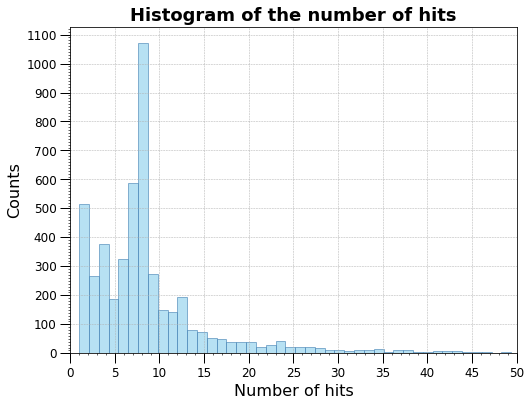

In [5]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
setup_graph_1(ax)

counts, bins = np.histogram(Hit_number, bins=70)
ax.hist(bins[:-1], bins, alpha=0.6, color='skyblue', ec = "steelblue", weights=counts, label='Histogram');

This histogram shows the counts registered per number of hit. It is possible to distinguish a remarkable peak centered around the value $7$. Since it is evident that most of the statistics can be found close to that peak, we decided to keep only those events with number of hits in the interval $3-9$. In particular:

- the lower limit has been set to $3$ hits because it was requested that different hits were registered at least in three different layers in order to get enough event points to perform a linear interpolation;

- the upper limit has been set to $9$ hits, a restrictive condition necessary to get rid of confusing events which make it hard to spot the right local alignment.

### `Noise_reduction`

* **Input**
    - `Events`: list of dataframes related to the different events stored into the file
    - `Hit_number`: list of the number of hits per each event
* **Output**
    - `Events_filtered`: list of filtered dataframes 
    - `new_Hit_number`: filtered list of the number of hits per each event
    
This function is used in order to perform a preliminary filter to reduce the noise in our data. Here we only select the events with number of hits in the interval previously indicated. Moreover we implement a control to check if an event has hits simultaneously on both sides of the apparatus. Also in that case the event will be rejected. 
Finally, we require at least three hits in three different layers in order to have enough data for a later moment, when we will reconstruct the muons' tracks. 

In [6]:
def Noise_reduction(Events, Hit_number):
    mask = []
    for event, N_hit in zip(Events, Hit_number):
        if N_hit <= 3 or N_hit >= 9:
            selected = False

        else:
            # left chambers
            if (event["chamber"] >= 2).all():
                layer_count_ch2 = event[event["chamber"] == 2]["layer"].nunique()
                layer_count_ch3 = event[event["chamber"] == 3]["layer"].nunique()

                if(layer_count_ch2 >= 3 and layer_count_ch3 >= 3): # eventualmente togliere se troppo restrittivo, da fare alla fine
                    selected = True
                else:
                    selected = False
                
            # With hits on right chambers
            elif (event["chamber"] <= 1).all():
                layer_count_ch0 = event[event["chamber"] == 0]["layer"].nunique()
                layer_count_ch1 = event[event["chamber"] == 1]["layer"].nunique()

                if(layer_count_ch0 >= 3 and layer_count_ch1 >= 3):
                    selected = True
                else:
                    selected = False
            # With hits on both the left and right chambers
            else:
                selected = False 
        mask.append(selected)
    Events_filtered = []
    new_Hit_number = []
    
    for event, N_hit, i in zip(Events, Hit_number, mask):
        if i:
            Events_filtered.append(event)
            new_Hit_number.append(N_hit)
            
    return Events_filtered, new_Hit_number

Events, Hit_number = Noise_reduction(Events, Hit_number)

print("The number of events has been reduced to: ", len(Events))


The number of events has been reduced to:  1559


### 2. Selection of good events by distribution along x-coordinate

By looking at the distribution of the x-coordinates of the recorded hits, it is possible to observe a peak around a certain position, which depends on sign and module of the magnetic field. As a matter of fact, as we previously said, the sign of magnetic current determines which will be the side preferred by muon tracks. Hence we performed a histogram representing this x-coordinates distribution to choose the convenient region of interest for each run and and we cut then those events falling out of it.

### `setup_graph_2`

* **Input**
    - `ax`: label of the histogram to which the graphical settings are applied
* **Output**
    - personalized settings for the graph taken into account (such as axis ticks, x and y limits, line width of the borders and so on...)
    
The following two functions work in the same way as `setup_graph_1`, but for the histograms of the counts as a function of the global and local coordinates respectively.

In [7]:
def setup_graph_2_global(ax):
    ax.xaxis.set_major_locator(ticker.MultipleLocator(200))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(50))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(500))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(100))
    ax.tick_params(which= 'major', width=1.0, length=10, labelsize=12)
    ax.grid(linestyle="--", linewidth=0.5)
    ax.set_xlabel("Global x coordinate [mm]", fontsize=16)
    ax.set_ylabel("Counts", fontsize=16)
    ax.set_xlim(-1000, 1000)
    ax.set_title("Distribution of hits in global coordinates", fontsize=18, fontweight='bold')
    
def setup_graph_2_local(ax, t):
    ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(200))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(20))
    ax.tick_params(which= 'major', width = 1.0, length = 10, labelsize = 12)
    ax.grid(linestyle="--", linewidth = 0.5)
    ax.set_xlabel("Local x coordinate [mm]", fontsize = 16)
    ax.set_ylabel("Counts", fontsize = 16)
    ax.set_xlim(-10, 800)
    ax.set_title(t, fontsize = 16, fontweight = 'bold')
    ax.legend(loc = 'best', fontsize = 14)

In [8]:
# Support function defined to perform gaussian fits with optimize.curve_fit()

def gauss(x,sigma,mu,factor,cost):
    return (factor*(1/(sigma*(2*np.pi)**.5))*np.exp(-(x-mu)**2/(2*sigma**2))+cost)

### `glob_x`

* **Input**
    - `Events`: list of dataframes related to the different events stored into the file
    - `c` : array with the colors of the histogram 
* **Output**
    - Histogram of the distribution of hits in all four chambers as a function of their global x-coordinate    

In [9]:
def glob_x(Events, c):
    gl_x_left = np.empty(1)
    gl_x_right = np.empty(1)

    for event in Events:
        gl_x_left = np.append(gl_x_left,event['xleft_gl'])
        gl_x_right = np.append(gl_x_right,event['xright_gl'])

    array_g = np.append(gl_x_right,gl_x_left)
    fig = plt.figure(figsize=(7.5, 5))
    ax = fig.add_subplot(111)
    setup_graph_2_global(ax)
    ax.hist(array_g, bins = 100, alpha = 0.6, color =c[0] , ec = c[1]);

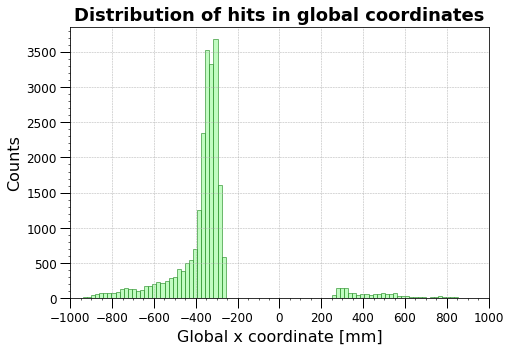

In [10]:
glob_x(Events,['palegreen','forestgreen'])

The first of the graphs shown above represents the distribution of hits in all four chambers as a function of their global x-coordinate. It can be seen that the majority of the hits is localized in the left portion of the apparatus (chambers 2 and 3). Since this analysis was carried out with the data from the run 260, we find out that with a negative magnetic current the $\mu^+$ are deflected to the left.

### `up_down_x`

* **Input**
    - `Events`: list of dataframes related to the different events stored into the file
    - `bins` : number of bins
    - `p0` : initial guess for the parameters of the gaussian fit
    - `x_fit` : x range over which the gaussian fit is plotted
    - `c` : array with the colors of the histogram 
* **Output**
    - Histogram of the distribution of the number of hits as function of their local x-coordinate for the upper and lower chamber

In [11]:
def up_down_x(Events, bins, p0, x_fit, c):
    array_x_left = np.empty(1)
    array_x_right = np.empty(1)

    if sign == 'pos':
        ch_U, ch_L = 0, 1

    else:
        ch_U, ch_L = 2, 3

    Events_upper = [ev[ev["chamber"] == ch_U] for ev in Events]
    Events_lower = [ev[ev["chamber"] == ch_L] for ev in Events]

    up_low = [Events_upper, Events_lower]
    titles = ["upper chamber", "lower chamber"]

    fig, (axU, axL) = plt.subplots(nrows = 1, ncols=2, figsize=(12, 5))
    fig.tight_layout(pad = 5.0)
    fig.subplots_adjust(top = 0.80)
    fig.suptitle("Hit distribution in local coordinates \n", fontsize = 20, fontweight='bold')

    axes = [axU,axL]
    P = []

    for ev, ax, t in zip(up_low, axes, titles):
        for event in ev:
            array_x_left = np.append(array_x_left,event['xleft_loc'])
            array_x_right = np.append(array_x_right,event['xright_loc'])

        np.delete(array_x_left,0)
        np.delete(array_x_right,0)
        array_l = np.append(array_x_right,array_x_left) 

        countsL, binsL = np.histogram(array_l, bins = 50)
        ax.hist(array_l, binsL[:-1], alpha = 0.6, color = c[0], ec = c[1], label = 'Histogram');

        paramsL, covarianceL = optimize.curve_fit(gauss, binsL[:-1], countsL, p0=p0)
        ax.plot(x_fit, gauss(x_fit,*paramsL), '-', color = c[2], lw = 2, label = 'Gaussian fit')
        setup_graph_2_local(ax, t)
          
        Range = [paramsL[1] - 4 * paramsL[0], paramsL[1] + 4 * paramsL[0]] 

        print('The gaussian parameters (𝜇 ± 𝜎) for the',t,'are:', round(paramsL[1],2),'±', round(paramsL[0],2), 
              '\n') 

        for i in range(2):       
            if Range[i]<0: Range[i]=0
            elif Range[i]>700: Range[i]=700
        P.append(Range)

    P = np.array(P) 
    range_P = [P.max(axis=0)[0],P.min(axis=0)[1]]

    print('and the interval Δx chosen for the filter: [',round(range_P[0],2), ',', round(range_P[1],2),']\n')
    return range_P
    

The gaussian parameters (𝜇 ± 𝜎) for the upper chamber are: 72.67 ± 23.87 

The gaussian parameters (𝜇 ± 𝜎) for the lower chamber are: 56.57 ± 30.96 

and the interval Δx chosen for the filter: [ 0.0 , 168.15 ]



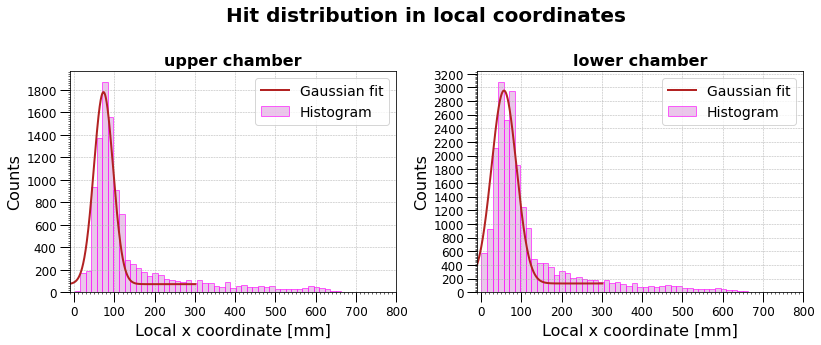

In [12]:
x = np.arange(-100, 300, 0.01) + 1
range_P = up_down_x(Events, 50, [30, 90, 1000, 0], x, ['plum','magenta','firebrick'] )

These two histograms, show the number of hits as function of their local x-coordinate for the left side of the setup (chambers 2 and 3). A gaussian fit was performed on these histograms to evaluate the peak region where most of the hits are located. For each chamber we calculated the mean value $\mu$ and the sigma $\sigma$ and consequently obtained two intervals $[\mu - 4\sigma, \mu + 4\sigma]$ for the good events' x-coordinates. Of course, since the chambers' dimensions are limited, we set the left limit to $0$ and the right one to $700$ when $\mu \pm 4\sigma$ fell outside these values. 

As condition on the global x coordinate for the filter we take the smallest interval to be left with those events which are registered by both chambers.

### `Filter_on_x_coord`

* **Input**
    - `Events`: list of dataframes related to the different events stored into the file
    - `sign`: sign of the magnetic current for the run considered
    - `range_P`: the smallest interval for the x coordinates found during the previous analysis for the upper and lower chambers
    - `Hit_number`: list of the number of hits per each event
* **Output**
    - `Final_Events`: list of dataframes related to the different events stored into the file after every filtering procedure implemented
    
With this function we perform an additional filter on the events to remove those with hits outside the region of interest found in the previous analysis. For this reason it is necessary to give as input the parameters of the previous fit and the sign of the current to decide whether we have to consider the left or right side. 

In [13]:
def Filter_on_x_coord(Events, sign, range_P, Hit_number):
    if sign == 'pos':
        ch_U = 0
        ch_L = 1
        Events = [ev[ev["chamber"] <= 1] for ev in Events]
    else:
        ch_U = 2
        ch_L = 3
        Events = [ev[ev["chamber"] >= 2] for ev in Events]
    
    Events = [ev[ev["xleft_loc"]  < range_P[1]] for ev in Events]
    Events = [ev[ev["xleft_loc"]  > range_P[0]] for ev in Events]    
    mask1 = [(ev["chamber"] == ch_U).any()  for ev in Events]
    mask2 = [(ev["chamber"] == ch_L).any()  for ev in Events]
    mask = mask1 or mask2
    Events_e=[]

    for event,i in zip(Events,mask):
        if i:
            Events_e.append(event)
    
    #To actually remove the empty dataframes
    Ev_corr_ch = []
    for event in Events_e:
        if not event.empty: 
            Ev_corr_ch.append(event)
    
    Final_Events, Hit_number = Noise_reduction(Ev_corr_ch, Hit_number)
    
    print('After having applied this last filter the percentage of the good events selected is:', 
          round((len(Events)/initial_ev_number)*100,2),'%')
    return Final_Events
                
Events = Filter_on_x_coord(Events, sign, range_P, Hit_number)


After having applied this last filter the percentage of the good events selected is: 32.26 %


## Plot of the setup and reconstruction of the tracks

Now that the data has been stripped from most of the noise, we can carry out a graphical representation of the setup and the distribution of the hits inside the chambers and its layers. 

### `Plot_Setup`

* **Input**
    - `Events`: list of dataframes related to the different events stored into the file
    - `sign`: sign of the magnetic current for the run considered
    - `n`: number of considered event

* **Output**
    - Plot of the setup in global coordinates showing the hits in the event considered
    
This function takes as input the list of all filtered events, the sign of the current and the number of the event we want to study. Then, using the geometrical parameters of the setup we display the four chambers as the rectangles below. Inside of them, we perform a scatter plot of the hits corresponding to the event. Since there is left-right ambiguity in the determination of the position, the blue-red paired dots in the display correspond to the two different possibilities that is whether the $\mu^+$ crossed the layer to the left or to the right of the anodic wires. The small rectangles highlight the layers in which the hits are registered.

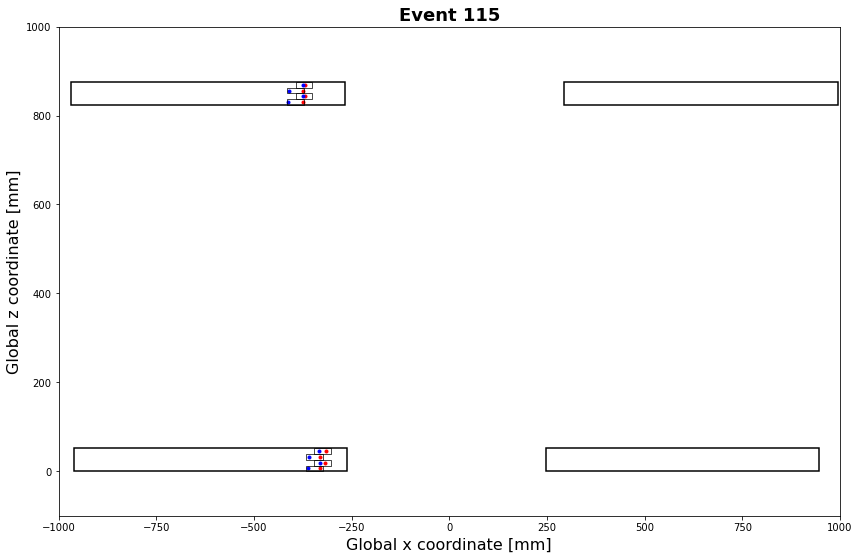

In [14]:
def Plot_Setup(Events, sign, n):
    
    plt.figure(figsize = (14,9))    
    plt.xlim(-1000, 1000)
    plt.ylim(-100, 1000) 
    plt.title(f"Event {n}", fontsize=18, fontweight='bold')
    plt.xlabel("Global x coordinate [mm]", fontsize=16)
    plt.ylabel("Global z coordinate [mm]", fontsize=16)
    
    ch_0, ch_1, ch_2, ch_3 = 0, 0, 0, 0
    ch_s = [ch_0, ch_1, ch_2, ch_3]
    
    x_vertex = np.array([(global_x_shifts[i] - 700) for i in range(4)])
    z_vertex = np.array([(global_z_shifts[i]) for i in range(4)])
 
    for chamber, i in zip(ch_s, range(4)):
        chamber = plt.Rectangle((x_vertex[i], z_vertex[i]), 700, ZCELL*4, ec = "k", fill = False, lw = 1.5)
        plt.gca().add_patch(chamber)
        
    event = Events[n]
    
    if sign == 'pos':
        ch_U = 0
        ch_L = 1
    else:
        ch_U = 2
        ch_L = 3
    
    event_chU = event[event["chamber"] == ch_U]
    event_chL = event[event["chamber"] == ch_L]

    event_chs = [event_chU, event_chL]
    ev_ch_lay_list, ev1_ch_lay_list  = [], []
    event_chs_lay_list = [ev_ch_lay_list, ev1_ch_lay_list]             
 

    for ev, ev_chs in zip(event_chs, event_chs_lay_list):
        for i in range(4):

            ev_chs.append(ev[ev["layer"] == i+1])
            x_wire = (ev_chs[i]['xleft_gl'].values + ev_chs[i]['xright_gl'].values)/2
            z_wire = ev_chs[i]['z_global'].values

            plt.scatter(ev_chs[i]['xleft_gl'].values, ev_chs[i]['z_global'].values, c = 'r', marker = '.')
            plt.scatter(ev_chs[i]['xright_gl'].values, ev_chs[i]['z_global'].values, c = 'b',marker = '.')

            x_vert_cell = np.array([x_wire-XCELL/2])
            z_vert_cell = np.array([z_wire-ZCELL/2])

            if x_vert_cell.size == 0: continue 
            else:
                layer = plt.Rectangle((x_vert_cell[0][0], z_vert_cell[0][0]), XCELL, ZCELL, ec = "k", fill = False, lw = 0.7)
                plt.gca().add_patch(layer)
    
    return

Plot_Setup(Events, sign, 115)


### `Select_xlim`

* **Input**
    - `event_ch`: pandas dataframe of the considered event containing information regarding upper or lower chambers
* **Output**
    - `ch_limits`: list with x limits for the subplots of upper or lower chambers (to get the correct zoom in)
    
This function allows to determine the optimal x-axis limit we must set to obtain a close-up of the chamber near the layers where the hits are located. 

In [15]:
def Select_xlim(event_ch):     
    rows, ch_limits = [], []
    for i in range(4):
        rows.append(event_ch[event_ch['layer'] == i+1])
        xL_values = np.array(rows[i]['xleft_gl'].values)
        xR_values = np.array(rows[i]['xright_gl'].values)
        x_values = np.append(xL_values, xR_values)
    
    ch_limits.append(np.min(x_values)-50)
    ch_limits.append(np.max(x_values)+50)
    
    return ch_limits             

### `X_Combinations`

* **Input**
    - `event_ch`: pandas dataframe of the considered event containing information regarding upper or lower chambers
* **Output**
    - `X`: list containing all possible combinations of x-coordinates taking only one point at a time for each layer

In [16]:
def X_Combinations(event_ch):    
    
    rows, L = [], []
    
    for i in range(4):
        rows.append(event_ch[event_ch['layer'] == i+1])
        xL_values = np.array(rows[i]['xleft_gl'].values)
        xR_values = np.array(rows[i]['xright_gl'].values)
        x_values = np.append(xL_values, xR_values)
        L.append(list(x_values))
   
    for i in L:
        if len(i) == 0:
            i.append(0)
        else:
            continue
    X = np.array([(h1,h2,h3,h4) for h1 in L[0] for h2 in L[1] for h3 in L[2] for h4 in L[3]])
    
    return X

### `Best_fit`

* **Input**
    - `X`: list of all possible combinations of x-coordinates taking one point for each layer
    - `z`: list of ordered z-coordinates for each layer
* **Output**
    - `m`: slope of the line corresponding to best fit among the possible combinations of x-coordinates 
    - `q`: intercept of the line corresponding to best fit among the possible combinations of x-coordinates
    - `x_opt`: optimal x-coordinates corresponding to the ones with the minimum standard error of the mean
    - `z_opt`: optimal z-coordinates corresponding to the ones with the minimum standard error of the mean
   
With this function we try to the determine for which of the combinations stored in X, the standard error of the mean is the smallest. As a matter of fact, since the tracks are almost vertical, we expect the global x-coordinates to have similar absolute values. We initialize the variable `min_err` to a big value and then update it every time a lower value is found. When the minimum value is found, we perform a linear regression with the x and z corresponding to that error. The output of the function are the parameters of this fit and the optimal x and z coordinates. 

In [17]:
def Best_fit(X, z):
        
    min_err = 10000 
    
    for x in X:
        z_filter = z[x!=0]
        x = x[x!=0]
        err = stats.sem(x)
        
        if min_err > err:
            
            min_err = err
            x_opt = x
            z_opt = z_filter
    m, q, _ , _, _ = stats.linregress(x_opt, z_opt)  
        
    return m, q, x_opt, z_opt

### `Local_Fit`

* **Input**
    - `Events`: list of dataframes related to the different events stored into the file
    - `sign`: sign of the magnetic current for the run considered
    - `n`: number of considered event
* **Output**
    - `best_fit_chs`: list containing the parameters of the two local fits for the upper and lower chambers and the coordinates of the points selected from the local fit
    
Using the previously defined functions `X_Combinations` and `Best_fit` this function allows to obtain a list with the parameters of the local fits taking as input the event considered and the sign of the current. Before calling those functions we split the dataframe into two separate ones: one for the upper chamber `event_chU` and one for the lower `event_chL`. Then we repeat the same procedure for both dataframes.

Finally we plot the lines corresponding to these fits over the scheme of the setup obtained calling again `Plot_Setup`.

Dataframe for the event considered:


,chamber,layer,xleft_loc,xright_loc,time,xleft_gl,xright_gl,z_local,z_global
0,2.0,1.0,101.60,108.40,62.5,-369.00,-375.80,45.5,869.0
1,2.0,3.0,102.40,107.60,48.3,-369.80,-375.00,19.5,843.0
2,2.0,2.0,108.40,143.60,326.7,-375.80,-411.00,32.5,856.0
3,2.0,4.0,107.30,144.70,347.5,-374.70,-412.10,6.5,830.0
4,3.0,1.0,54.88,71.12,150.8,-316.38,-332.62,45.5,45.5
5,3.0,3.0,57.08,68.92,110.0,-318.58,-330.42,19.5,19.5
6,3.0,2.0,70.18,97.82,256.7,-331.68,-359.32,32.5,32.5
7,3.0,4.0,68.70,99.30,284.2,-330.20,-360.80,6.5,6.5




The slope and intercept parameters for the upper chamber are: m = -28.13  and q = -9707.13
The slope and intercept parameters for the lower chamber are: m = -14.38  and q = -4736.57 



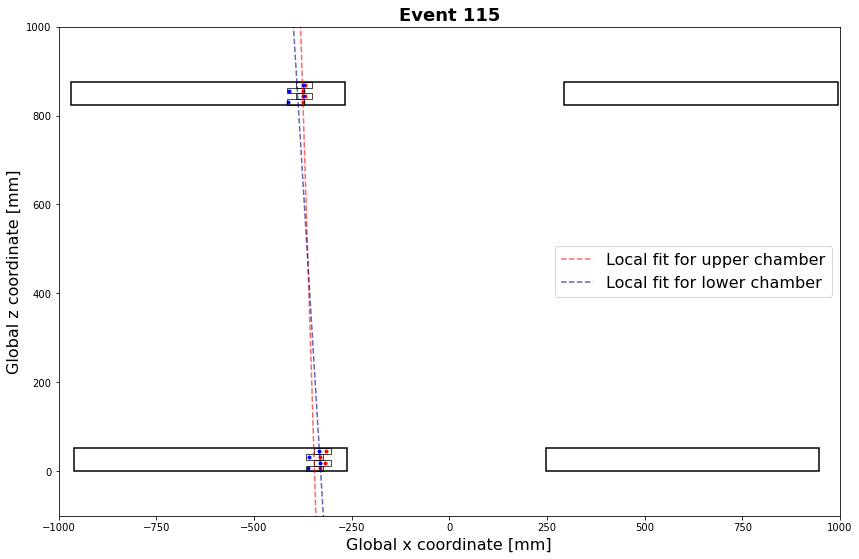

In [18]:
def Local_Fit(Events, sign, n):
    if sign == 'pos':
        ch_U = 0
        ch_L = 1
        Events = [ev[ev["chamber"] <= 1] for ev in Events]
        
    else:
        ch_U = 2
        ch_L = 3
        Events = [ev[ev["chamber"] >= 2] for ev in Events]  
        
    z_U = np.array([869.0, 856.0, 843.0, 830.0])
    z_L = np.array([45.5, 32.5, 19.5, 6.5])   

    event = Events[n]
   
    event_chU = event[event["chamber"] == ch_U]
    event_chL = event[event["chamber"] == ch_L]
    
    event_chs = [event_chU, event_chL]
    z_chs = [z_U, z_L]
    
    best_fit_chs = []
    
    for ch, z in zip(event_chs, z_chs):
        X = X_Combinations(ch)
        m, q, x_f, z_f = Best_fit(X, z)
        best_fit_chs.append([m, q, x_f, z_f])
    
    return best_fit_chs

p = 115

print("Dataframe for the event considered:")
display(Events[p])
print('\n')

best_fit_chs = Local_Fit(Events, sign, p)

Plot_Setup(Events, sign, p)
x = np.linspace(-1000, 1000, 20000)

labels = ["Local fit for upper chamber", "Local fit for lower chamber"]
color = ["r", "navy"]

for i, j, k in zip(best_fit_chs, range(2), range(2)):
    plt.plot(x, i[0]*x + i[1], color[j], linestyle = "--", alpha = 0.6, label = labels[k])
    plt.legend(loc = 7, fontsize = 16)

print(f"The slope and intercept parameters for the upper chamber are: m = {round(best_fit_chs[0][0],2)}", 
      f" and q = {round(best_fit_chs[0][1],2)}")
print(f"The slope and intercept parameters for the lower chamber are: m = {round(best_fit_chs[1][0],2)}",
      f" and q = {round(best_fit_chs[1][1],2)}", "\n")


Although the results are different depending on the event considered, we can see that in almost all cases the two local fits are not perfectly consistent with each other. This is due to the fact that the points are concentrated in a very small region and the results of their fit cannot be easily extended over the whole area of the setup. In fact, far from the fitted region, the errors on the parameters make the results unreliable.

The purpose of performing this local fit is to individuate and save the best candidate points related to the trajectory of the muon crossing each chamber. In particular, this procedure allows us to gather their x and z coordinates and reject all the other points which are not involved into the fit.

### `Global_Fit`

* **Input**
    - `best_fit_chs`: list containing the parameters of the two local fits for the upper and lower chambers and the coordinates of the points selected from the local fit
* **Output**
    - `m_gl`: global fit line slope parameter
    - `q_gl`: global fit line intercept parameter

This function takes as input the list `best_fit_chs` and collects in two numpy arrays the optimal x and z coordinates from both chambers previously found. Then, by performing on them a linear regression, it returns the global fit parameters as output.

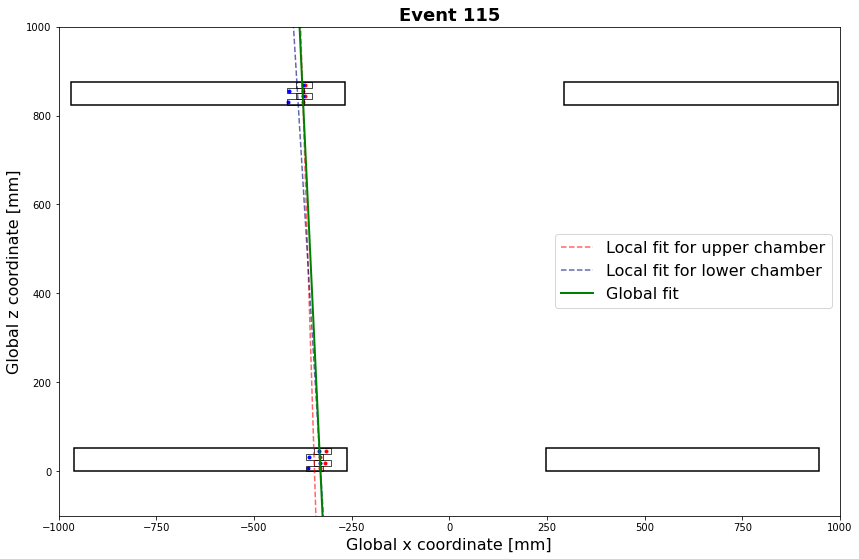

The slope and intercept parameters for the global fit are: m = -18.67  and q = -6159.23


In [19]:
def Global_Fit(best_fit_chs):
    sel_x = np.concatenate([best_fit_chs[1][2], best_fit_chs[0][2]])
    sel_z = np.concatenate([best_fit_chs[1][3], best_fit_chs[0][3]])
    m_gl, q_gl, _ , _, _ = stats.linregress(sel_x, sel_z)
    return m_gl, q_gl

p = 115

best_fit_chs = Local_Fit(Events, sign, p)

Plot_Setup(Events, sign, p)

x = np.linspace(-1000, 1000, 20000)

labels = ["Local fit for upper chamber", "Local fit for lower chamber"]
color = ["r", "navy"]

for i, j, k in zip(best_fit_chs, range(2), range(2)):
    plt.plot(x, i[0]*x + i[1], color[j], linestyle = "--", alpha = 0.6, label = labels[k])

m_gl, q_gl = Global_Fit(best_fit_chs)
plt.plot(x, m_gl*x + q_gl, c = "g", lw = 2, label = 'Global fit')
plt.legend(loc = 7, fontsize = 16)

plt.show()

print(f"The slope and intercept parameters for the global fit are: m = {round(m_gl,2)}", 
      f" and q = {round(q_gl,2)}")

The global fit represent our best estimate of the trajectory across the two chambers for the $\mu^+$ in the event considered.

### `Zoom_Event`

* **Input**
    - `Events`: list of dataframes related to the different events stored into the file
    - `sign`: sign of the magnetic current for the run considered
    - `n`: number of considered event
    
* **Output**
    - Subplots of each chamber crossed during the event considered with points associated to the hits recorded and fits.
    
We use this function we repeat the previous procedure zooming over the regions where the hits are located insider the two chambers.

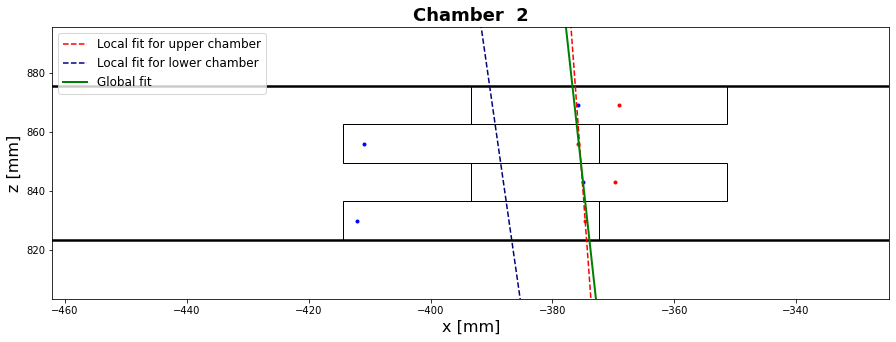

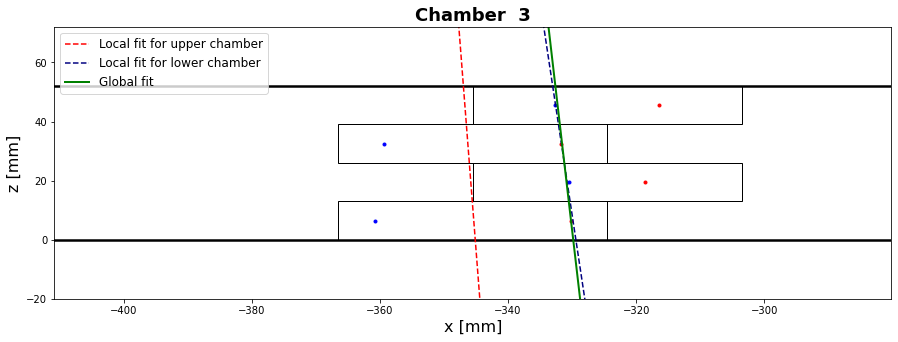

In [20]:
def Zoom_event(Events, sign, n):
    ch_U, ch_L = 0,0 

    if sign == 'pos':
        ch_U, ch_L = 0,1 
    else:
        ch_U, ch_L = 2,3

    event = Events[n]
    #To separate upper and lower chamber events
    event_chU = event[event["chamber"] == ch_U]
    event_chL = event[event["chamber"] == ch_L]    
    event_chs = [event_chU, event_chL]
    # Choose left and right x_limits depending on x coordinates of hit
    chU_limits = Select_xlim(event_chU)
    chL_limits = Select_xlim(event_chL) 
    ch_limits = [chU_limits,chL_limits]
    chs=[ch_U,ch_L]
    ylims = [[803.5, 895.5],[-20,72]]
    
    for ch,ch_L,ylim in zip(chs,ch_limits,ylims):
            
        plt.figure(figsize = (15,5)) 
        # Determine vertex of upper chamber
        x_vertex = np.array(global_x_shifts[ch] - 700) 
        z_vertex = np.array(global_z_shifts[ch])    
        # Plot chamber
        chamber = plt.Rectangle((x_vertex, z_vertex), 700, ZCELL*4, ec = "k", fill = False, lw = 2.5) 
        plt.gca().add_patch(chamber) 
        # Plot points and layers
        event_ch = event[event["chamber"] == ch] 
        ev_ch_lay_list = [] 
        for i in range(4):
            ev_ch_lay_list.append(event_ch[event_ch["layer"] == i+1])
            x_wire = (ev_ch_lay_list[i]['xleft_gl'].values + ev_ch_lay_list[i]['xright_gl'].values)/2
            z_wire = ev_ch_lay_list[i]['z_global'].values
            plt.scatter(ev_ch_lay_list[i]['xleft_gl'].values,ev_ch_lay_list[i]['z_global'].values, c='r', marker='.')
            plt.scatter(ev_ch_lay_list[i]['xright_gl'].values,ev_ch_lay_list[i]['z_global'].values, c='b',marker='.')

            x_vertex_cell = np.array([x_wire-XCELL/2])
            z_vertex_cell = np.array([z_wire-ZCELL/2])

            if x_vertex_cell.size == 0: continue 
            else:
                layer = plt.Rectangle((x_vertex_cell[0][0], z_vertex_cell[0][0]), XCELL, ZCELL, ec = "k", fill = False, lw = 1)
                plt.gca().add_patch(layer) 

        #Plot local fit
        x = np.linspace(-1000, 1000, 20000)
        labels = ["Local fit for upper chamber", "Local fit for lower chamber"]
        color = ["r", "navy"]

        for i, j, k in zip(best_fit_chs, range(2), range(2)):
            plt.plot(x, i[0]*x + i[1], color[j], linestyle = '--', label = labels[k])

        #Plot global fit
        m_gl, q_gl = Global_Fit(best_fit_chs)
        plt.plot(x, m_gl*x + q_gl, c = "g", lw = 2, label = 'Global fit')

        #Graphic settings of plot
        plt.xlim(ch_L[0], ch_L[1]) 
        plt.ylim(ylim[0],ylim[1])
        plt.title(f"Chamber  {ch}", fontsize=18, fontweight='bold')
        plt.xlabel("x [mm]", fontsize=16)
        plt.ylabel("z [mm]", fontsize=16)
        plt.legend(loc = 'best', fontsize = 12)

    return

Zoom_event(Events, sign, 115)


## Analysis

In the following paragraphs we sum up the results of the analysis performed on the four calibration runs starting by summing up the results obtained for the `"data_260.txt"` file and then proceding with the other three files. 

### Run 260 -  Energy: $22$ GeV - Magnet current: $-580$ A

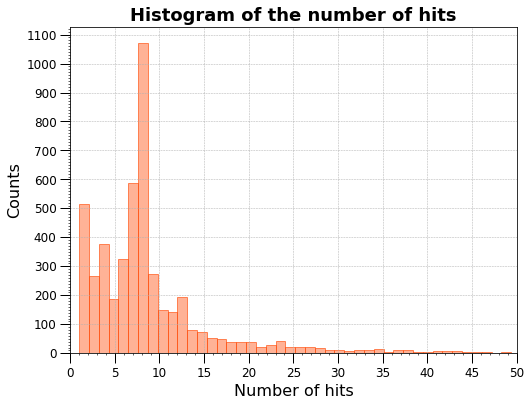

In [21]:
file_name = "data_260.txt"
sign = 'neg'

Events, Hit_number = Read_data(file_name)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
setup_graph_1(ax)

counts, bins = np.histogram(Hit_number, bins=70)
ax.hist(bins[:-1], bins, alpha = 0.6, color = 'coral', ec = 'orangered', weights=counts, label='Histogram');

Events, Hit_number = Noise_reduction(Events, Hit_number)

The gaussian parameters (𝜇 ± 𝜎) for the upper chamber are: 72.62 ± 23.73 

The gaussian parameters (𝜇 ± 𝜎) for the lower chamber are: 56.57 ± 31.05 

and the interval Δx chosen for the filter: [ 0.0 , 167.53 ]

After having applied this last filter the percentage of the good events selected is: 32.26 %


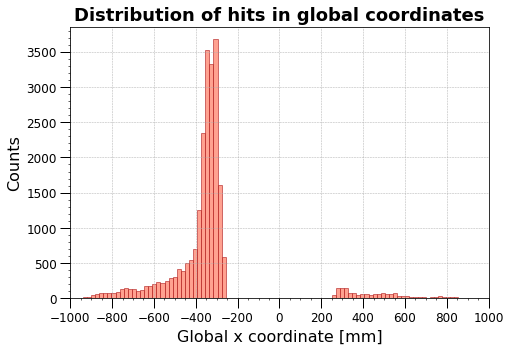

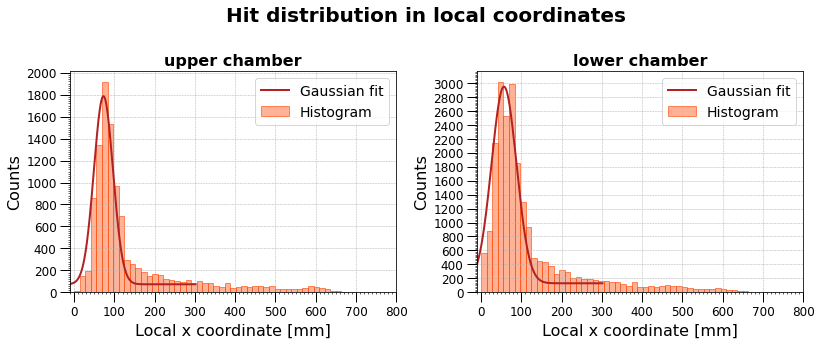

In [22]:
glob_x(Events,['tomato','firebrick'])

x = np.arange(-100, 300, 0.01) + 1
range_P = up_down_x(Events, 50, [30, 90, 1000, 0], x, ['coral', 'orangered','firebrick'] )

Events = Filter_on_x_coord(Events, sign, range_P, Hit_number)

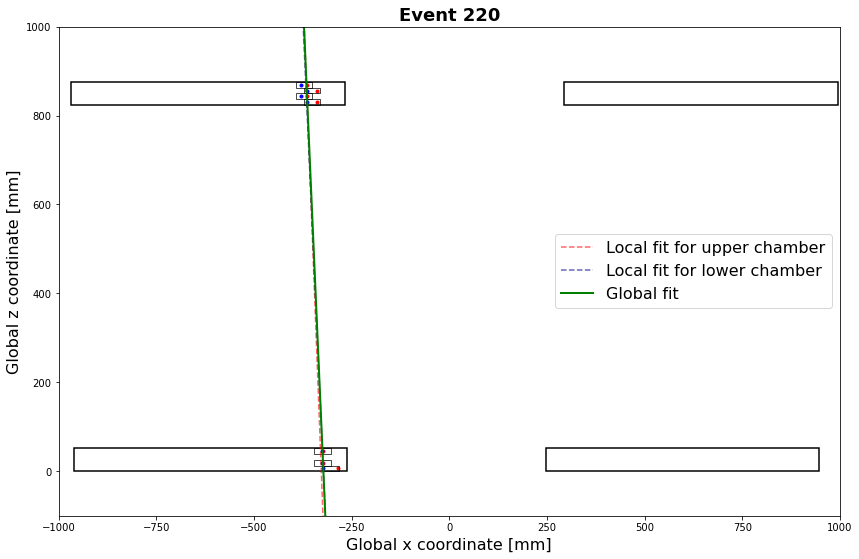

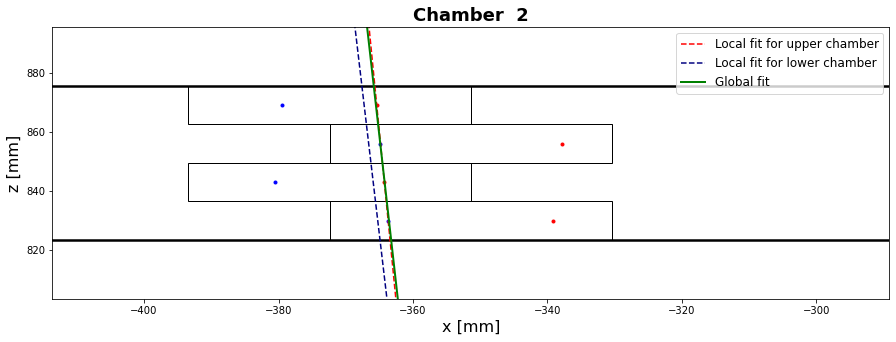

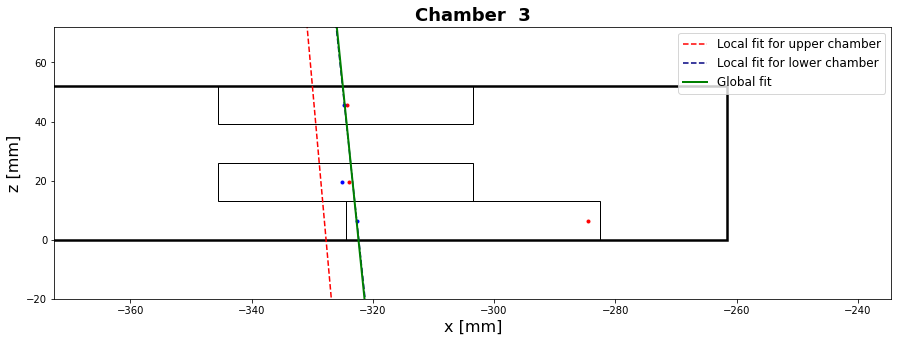

In [23]:
p = 220

best_fit_chs = Local_Fit(Events, sign, p)

Plot_Setup(Events, sign, p)

x = np.linspace(-1000, 1000, 20000)
labels = ["Local fit for upper chamber", "Local fit for lower chamber"]
color = ["r", "navy"]

for i, j, k in zip(best_fit_chs, range(2), range(2)):
    plt.plot(x, i[0]*x + i[1], color[j], linestyle = "--", alpha = 0.6, label = labels[k])
    plt.legend(loc =7, fontsize = 16)

m_gl, q_gl = Global_Fit(best_fit_chs)
plt.plot(x, m_gl*x + q_gl, c = "g", lw = 2, label = 'Global fit')
plt.legend(loc = 7, fontsize = 16)

plt.show()

Zoom_event(Events, sign, p)

### Run 261 - Energy: $18$ GeV - Magnet current: $-850$ A

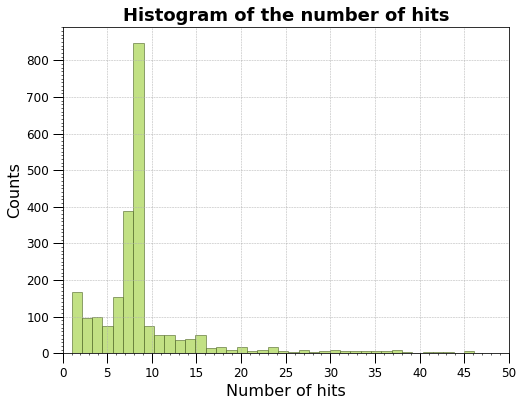

In [24]:
file_name = "data_261.txt"
sign = 'neg'

Events, Hit_number = Read_data(file_name)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
setup_graph_1(ax)

counts, bins = np.histogram(Hit_number, bins=70)
ax.hist(bins[:-1], bins, alpha = 0.6, color = 'yellowgreen', ec = 'darkolivegreen', weights=counts);

Events, Hit_number = Noise_reduction(Events, Hit_number)

The gaussian parameters (𝜇 ± 𝜎) for the upper chamber are: 209.32 ± 28.68 

The gaussian parameters (𝜇 ± 𝜎) for the lower chamber are: 183.16 ± 42.5 

and the interval Δx chosen for the filter: [ 94.59 , 324.04 ]

After having applied this last filter the percentage of the good events selected is: 22.97 %


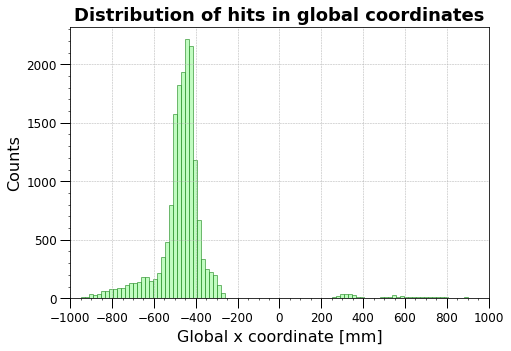

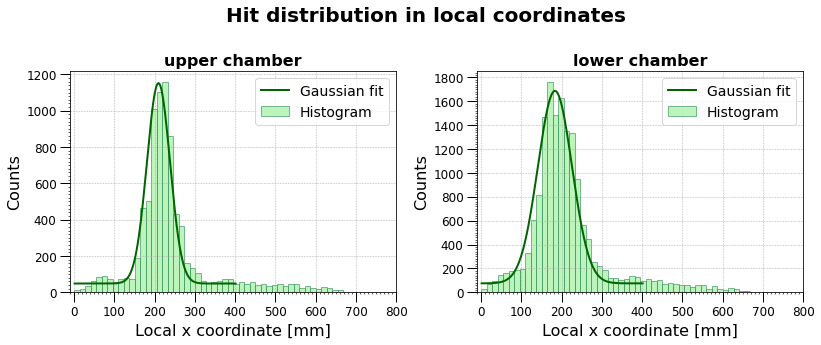

In [25]:
glob_x(Events,['palegreen','forestgreen'])

x = np.arange(0, 400, 0.01) + 1
range_P = up_down_x(Events, 50, [50, 200, 50000, 0], x, ['lightgreen', 'seagreen','darkgreen'] )

Events = Filter_on_x_coord(Events, sign, range_P, Hit_number)

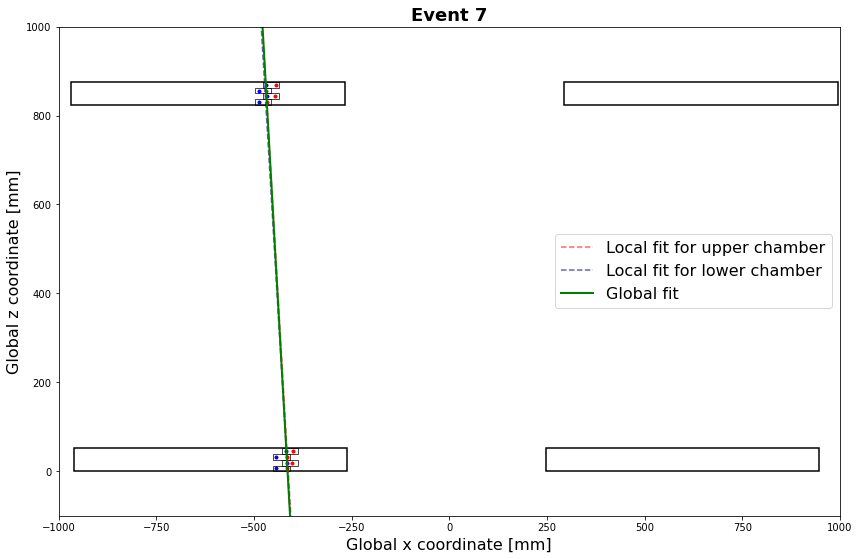

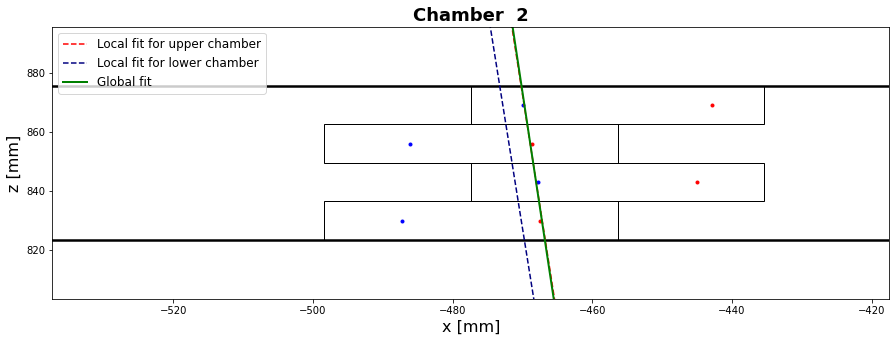

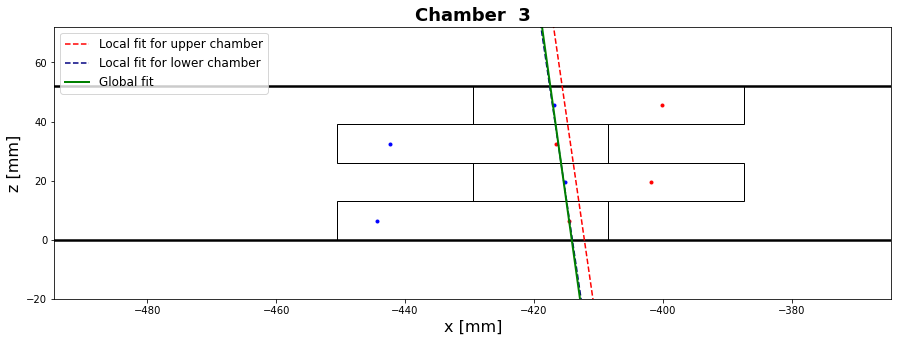

In [26]:
p = 7

best_fit_chs = Local_Fit(Events, sign, p)

Plot_Setup(Events, sign, p)

x = np.linspace(-1000, 1000, 20000)
labels = ["Local fit for upper chamber", "Local fit for lower chamber"]
color = ["r", "navy"]

for i, j, k in zip(best_fit_chs, range(2), range(2)):
    plt.plot(x, i[0]*x + i[1], color[j], linestyle = "--", alpha = 0.6, label = labels[k])
    plt.legend(loc = 7, fontsize = 16)

m_gl, q_gl = Global_Fit(best_fit_chs)
plt.plot(x, m_gl*x + q_gl, c = "g", lw = 2, label = 'Global fit')
plt.legend(loc = 7, fontsize = 16)

plt.show()

Zoom_event(Events, sign, p)

### Run 262 - Energy: $18$ GeV - Magnet current: $850$ A

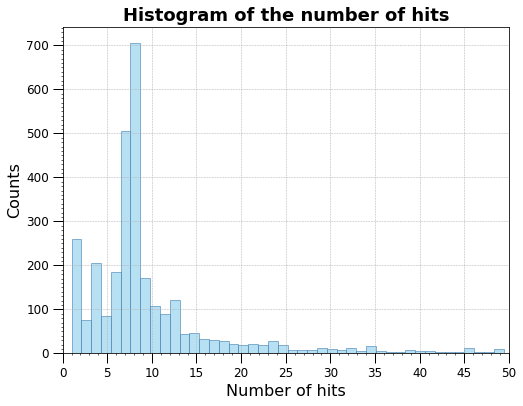

In [27]:
file_name = "data_262.txt"
sign = 'pos'

Events, Hit_number = Read_data(file_name)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
setup_graph_1(ax)

counts, bins = np.histogram(Hit_number, bins = 60)
ax.hist(bins[:-1], bins, alpha = 0.6, color='skyblue', ec = "steelblue", weights=counts);

Events, Hit_number = Noise_reduction(Events, Hit_number)

The gaussian parameters (𝜇 ± 𝜎) for the upper chamber are: 473.93 ± 27.62 

The gaussian parameters (𝜇 ± 𝜎) for the lower chamber are: 478.8 ± 26.49 

and the interval Δx chosen for the filter: [ 372.85 , 584.42 ]

After having applied this last filter the percentage of the good events selected is: 24.19 %


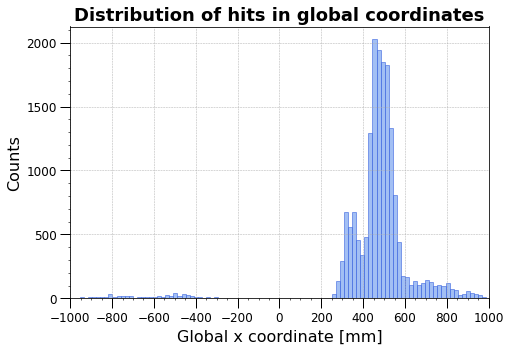

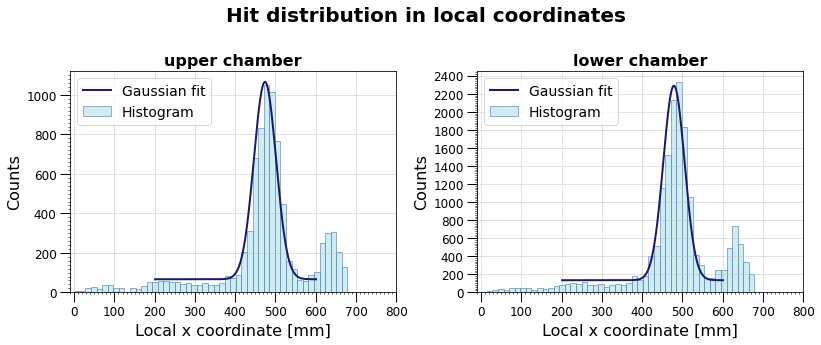

In [28]:
glob_x(Events,['cornflowerblue','royalblue'])

x = np.arange(200, 600, 0.01) + 1
range_P = up_down_x(Events, 50, [20, 490, 1000, 0], x, ['powderblue', 'steelblue','midnightblue'] )

Events = Filter_on_x_coord(Events, sign, range_P, Hit_number)

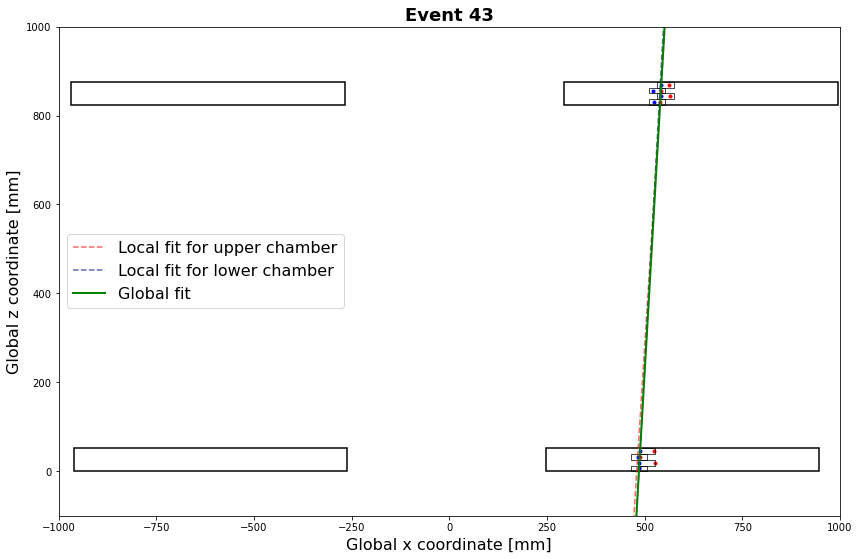

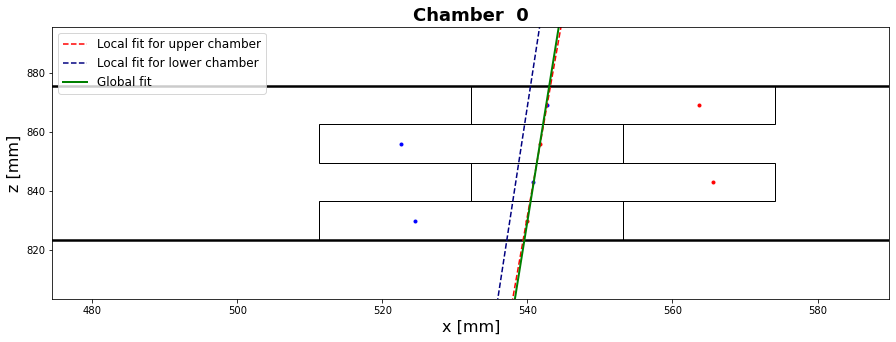

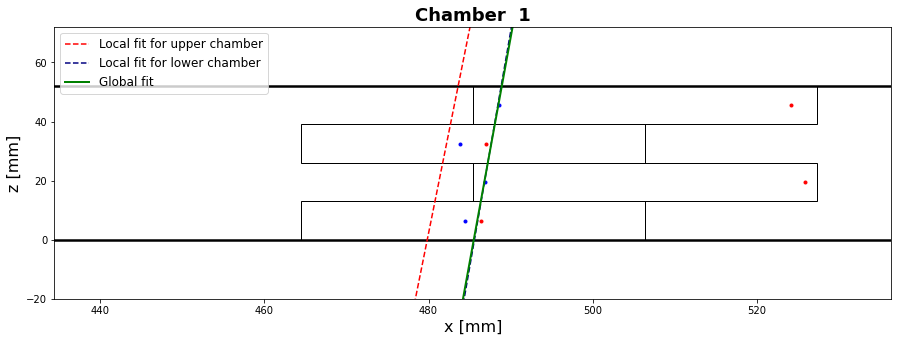

In [29]:
p = 43

best_fit_chs = Local_Fit(Events, sign, p)

Plot_Setup(Events, sign, p)

x = np.linspace(-1000, 1000, 20000)
labels = ["Local fit for upper chamber", "Local fit for lower chamber"]
color = ["r", "navy"]

for i, j, k in zip(best_fit_chs, range(2), range(2)):
    plt.plot(x, i[0]*x + i[1], color[j], linestyle = "--", alpha = 0.6, label = labels[k])
    plt.legend(loc = 6, fontsize = 16)

m_gl, q_gl = Global_Fit(best_fit_chs)
plt.plot(x, m_gl*x + q_gl, c = "g", lw = 2, label = 'Global fit')
plt.legend(loc = 6, fontsize = 16)

plt.show()

Zoom_event(Events, sign, p)

### Run 263 - Energy: $22$ GeV - Magnet current: $580$ A

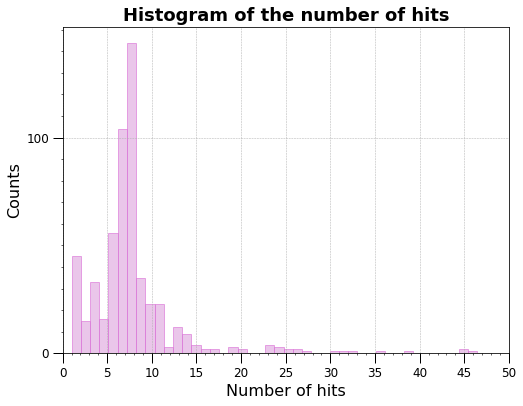

In [30]:
file_name = "data_263.txt"
sign = 'pos'

Events, Hit_number = Read_data(file_name)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
setup_graph_1(ax)

counts, bins = np.histogram(Hit_number, bins = 60)
ax.hist(bins[:-1], bins, alpha = 0.6, color='plum', ec = "orchid", weights=counts);

Events, Hit_number = Noise_reduction(Events, Hit_number)

The gaussian parameters (𝜇 ± 𝜎) for the upper chamber are: 620.41 ± 20.24 

The gaussian parameters (𝜇 ± 𝜎) for the lower chamber are: 614.65 ± 22.89 

and the interval Δx chosen for the filter: [ 539.43 , 700.0 ]

After having applied this last filter the percentage of the good events selected is: 5.23 %


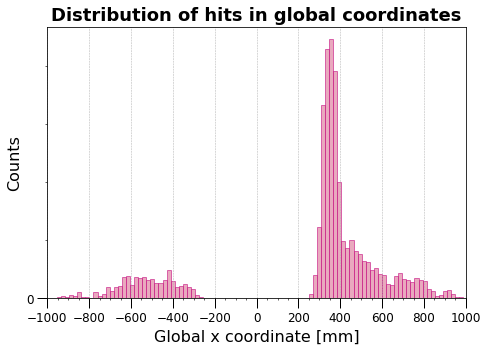

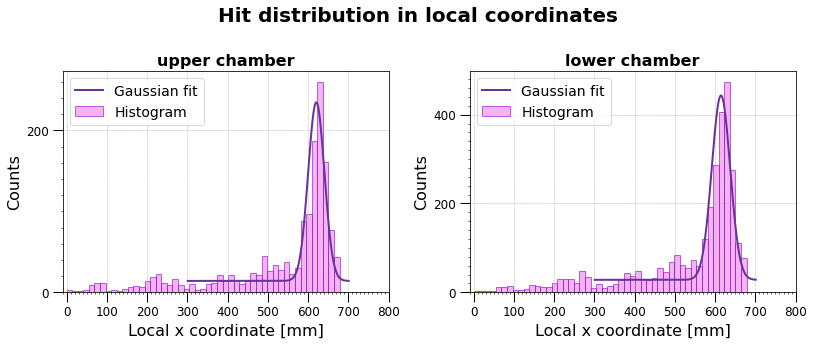

In [31]:
glob_x(Events,['palevioletred','mediumvioletred'])

x = np.arange(300, 700, 0.01) + 1
range_P = up_down_x(Events, 50, [20, 650, 1000, 0], x, ['violet', 'darkviolet','rebeccapurple'] )

Events = Filter_on_x_coord(Events, sign, range_P, Hit_number)

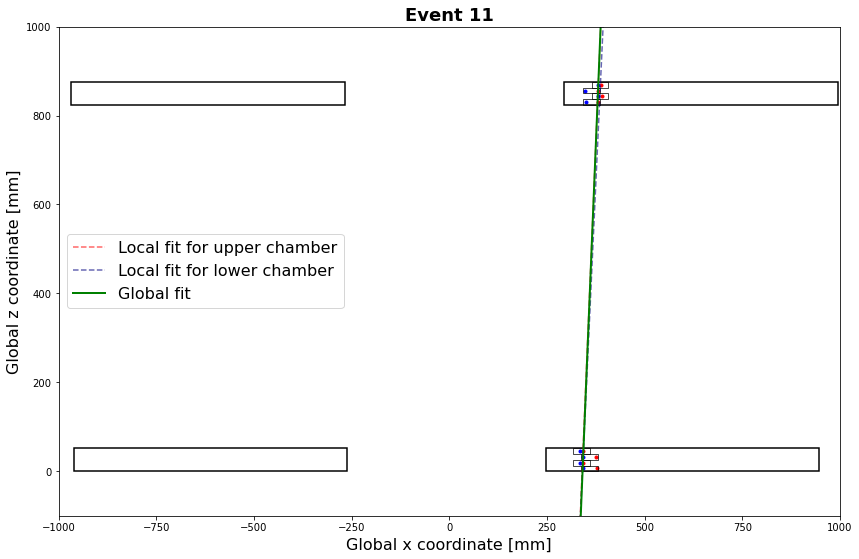

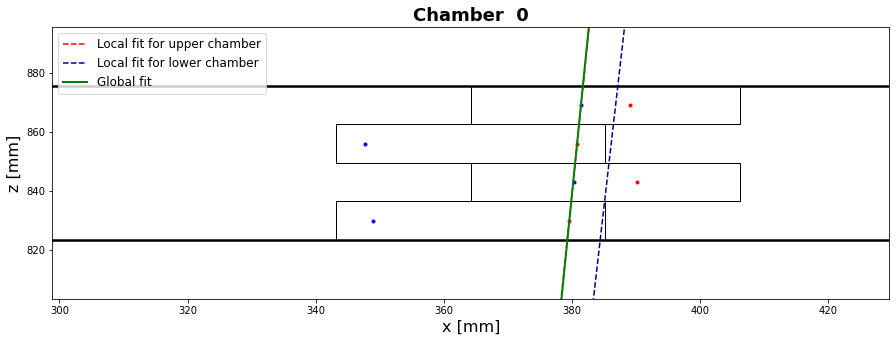

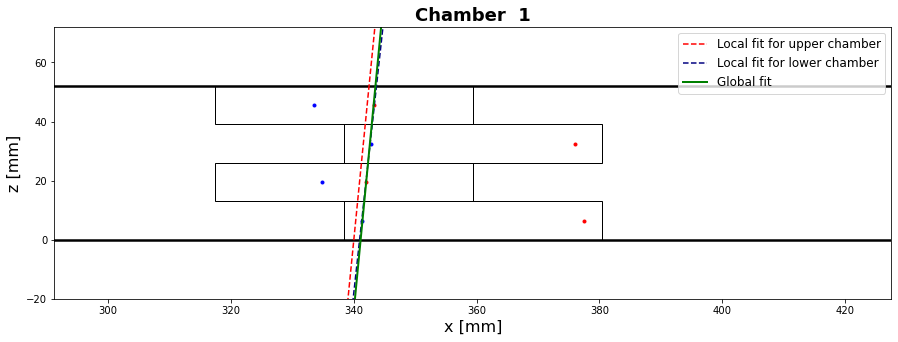

In [32]:
p = 11

best_fit_chs = Local_Fit(Events, sign, p)

Plot_Setup(Events, sign, p)

x = np.linspace(-1000, 1000, 20000)
labels = ["Local fit for upper chamber", "Local fit for lower chamber"]
color = ["r", "navy"]

for i, j, k in zip(best_fit_chs, range(2), range(2)):
    plt.plot(x, i[0]*x + i[1], color[j], linestyle = "--", alpha = 0.6, label = labels[k])
    plt.legend(loc = 6, fontsize = 16)

m_gl, q_gl = Global_Fit(best_fit_chs)
plt.plot(x, m_gl*x + q_gl, c = "g", lw = 2, label = 'Global fit')
plt.legend(loc = 6, fontsize = 16)

plt.show()

Zoom_event(Events, sign, p)

# Conclusion

We can conclude by saying that the procedure implemented for the filtering of the datasets is quite satisfying since for almost all events in all the runs we manage to detect the track and reconstruct its trajectory through the fitting procedure.

The price to pay is a very strong reduction of the number of events: we can see that even in the best case, less than 35% of the them are selected. In the following our results are summarized in a table:

| Run |  Selected events | x-range|
|-----|:-----:|:-----:|
| 260 | 32.26 %|[ 0 , 167.53 ]| 
| 261 | 22.97 %| [ 94.59 , 324.04 ]|
| 262 | 24.19 %|[ 372.85 , 584.42 ]|
| 263 | 5.23 %|[ 539.43 , 700.0 ]|

In particular the small percentage of acceptable events in the last run is mostly due to the fact that the file contained many null events. In fact it can be seen the range of the other run is of the same order of magnitude as for the others. The histograms for the number of hit per event is averagely peaked in the same region (about 7-8 hits).
Finally, it is worth noticing that in the histogram for the distribution of hits as a function of the local x-coordinate in Run  262 there is a slightly double-peaked structure, whose presence we are not able to fully explain. We decided to consider only the region of the major peak.